# Demo of `models.py`

In [2]:
from gcdyn import models, poisson, utils, mutators, bdms
import jax.numpy as np
from jax.config import config

config.update("jax_enable_x64", True)

## Set up truth

In [3]:
# (Deliberately avoiding rate parameters == constant 1, because a lot of bugs hide in this scenario)
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
    "extinct_sampling_probability": 0,
}

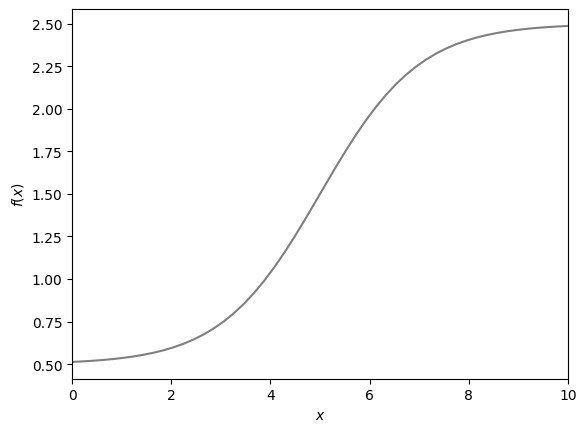

In [6]:
utils.plot_responses(true_parameters["birth_response"], x_range=(0, 10))

## Simulate some trees

In [4]:
seed = 10

PRESENT_TIME = 4

trees = bdms.sample_trees(n=5, t=PRESENT_TIME, init_x=1, **true_parameters, seed=seed)

for tree in trees:
    if true_parameters["extinct_sampling_probability"] == 1:
        tree._pruned = True
    elif true_parameters["extinct_sampling_probability"] == 0:
        tree.prune()

print(
    "After pruning: average of",
    sum(len(list(tree.traverse())) for tree in trees) / len(trees),
    "nodes per tree, over",
    len(trees),
    "trees.",
)

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 37 times.
Success: average of 100.0 nodes per tree, over 5 trees.
After pruning: average of 38.6 nodes per tree, over 5 trees.


## Computing likelihood

In [8]:
models.stadler_full_log_likelihood(
    trees=trees,
    **true_parameters,
    present_time=PRESENT_TIME,
    dtmax=0.01,
)

Array(-230.5527925, dtype=float64, weak_type=True)

## Maximum likelihood estimation of rate parameters

In [9]:
# Initialize with the truth

model = models.BirthDeathModel(
    log_likelihood=models.stadler_appx_log_likelihood,
    trees=trees,
    optimized_parameters={
        "birth_response": true_parameters["birth_response"],
        "death_response": true_parameters["death_response"],
    },
    fixed_parameters={
        "mutation_response": true_parameters["mutation_response"],
        "mutator": true_parameters["mutator"],
        "extant_sampling_probability": true_parameters["extant_sampling_probability"],
        "extinct_sampling_probability": true_parameters["extinct_sampling_probability"],
        "present_time": PRESENT_TIME,
    },
)

model.fit()

ScipyMinimizeInfo(fun_val=Array(223.65669084, dtype=float64, weak_type=True), success=True, status=0, iter_num=17)

In [10]:
model.parameters["birth_response"]

SigmoidResponse(xscale=0.9733255825455766, xshift=5.538441660208583, yscale=1.4196465099635436, yshift=0.0852267618100127)

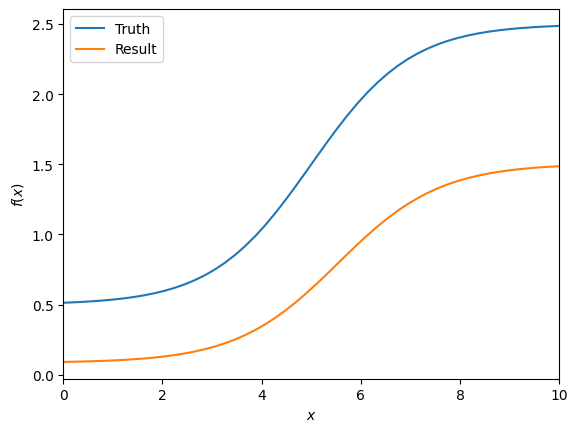

In [11]:
utils.plot_responses(
    Truth=true_parameters["birth_response"],
    Result=model.parameters["birth_response"],
    x_range=(0, 10),
)